# Dataset

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

In [2]:
from google.colab import drive
import os
drive.mount("/content/drive")
datadir = 'drive/My Drive/DATASET'

Mounted at /content/drive


In [3]:
IMAGE_SIZE = 224
data_path = os.path.join(datadir+'/images','*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

In [4]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [5]:
path = datadir+'/annotations'
text_files = [path+'/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

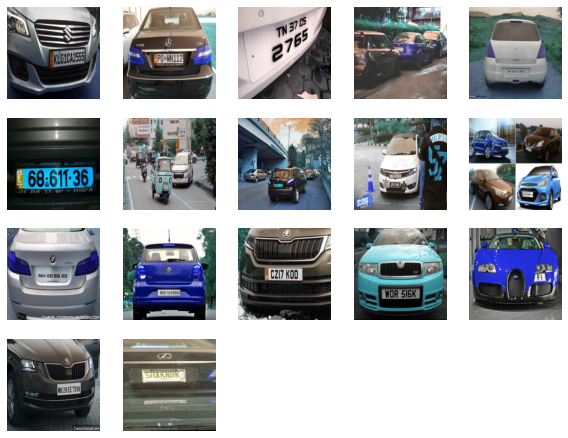

In [6]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

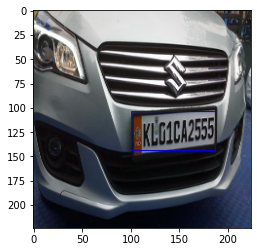

In [8]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

# CNN

In [9]:
#Transforming in array
X=np.array(X)
y=np.array(y)

#Renormalisation
X = X / 255
y = y / 255

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [11]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [12]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                         

In [13]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)


Epoch 1/50
10/10 [==============================] - 31s 1s/step - loss: 0.0418 - accuracy: 0.4534 - val_loss: 0.0244 - val_accuracy: 0.4286
Epoch 2/50
10/10 [==============================] - 3s 282ms/step - loss: 0.0143 - accuracy: 0.7267 - val_loss: 0.0173 - val_accuracy: 0.6571
Epoch 3/50
10/10 [==============================] - 3s 281ms/step - loss: 0.0077 - accuracy: 0.8553 - val_loss: 0.0151 - val_accuracy: 0.6000
Epoch 4/50
10/10 [==============================] - 3s 283ms/step - loss: 0.0041 - accuracy: 0.8328 - val_loss: 0.0152 - val_accuracy: 0.5714
Epoch 5/50
10/10 [==============================] - 3s 286ms/step - loss: 0.0024 - accuracy: 0.8778 - val_loss: 0.0152 - val_accuracy: 0.6857
Epoch 6/50
10/10 [==============================] - 3s 286ms/step - loss: 0.0015 - accuracy: 0.8907 - val_loss: 0.0154 - val_accuracy: 0.5714
Epoch 7/50
10/10 [==============================] - 3s 285ms/step - loss: 0.0010 - accuracy: 0.8971 - val_loss: 0.0146 - val_accuracy: 0.6571
Epoch 8/

In [14]:
model.save('my_model.h5', overwrite=True) 

# Testing & Results

In [15]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 89.66%


In [16]:
 y_cnn = model.predict(X_test)

In [17]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

100/100 [==============================] - 5s 36ms/step - loss: 0.0063 - accuracy: 0.8966
Test results 
 Loss: 0.006251399405300617 
 Accuracy 0.8965517282485962


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

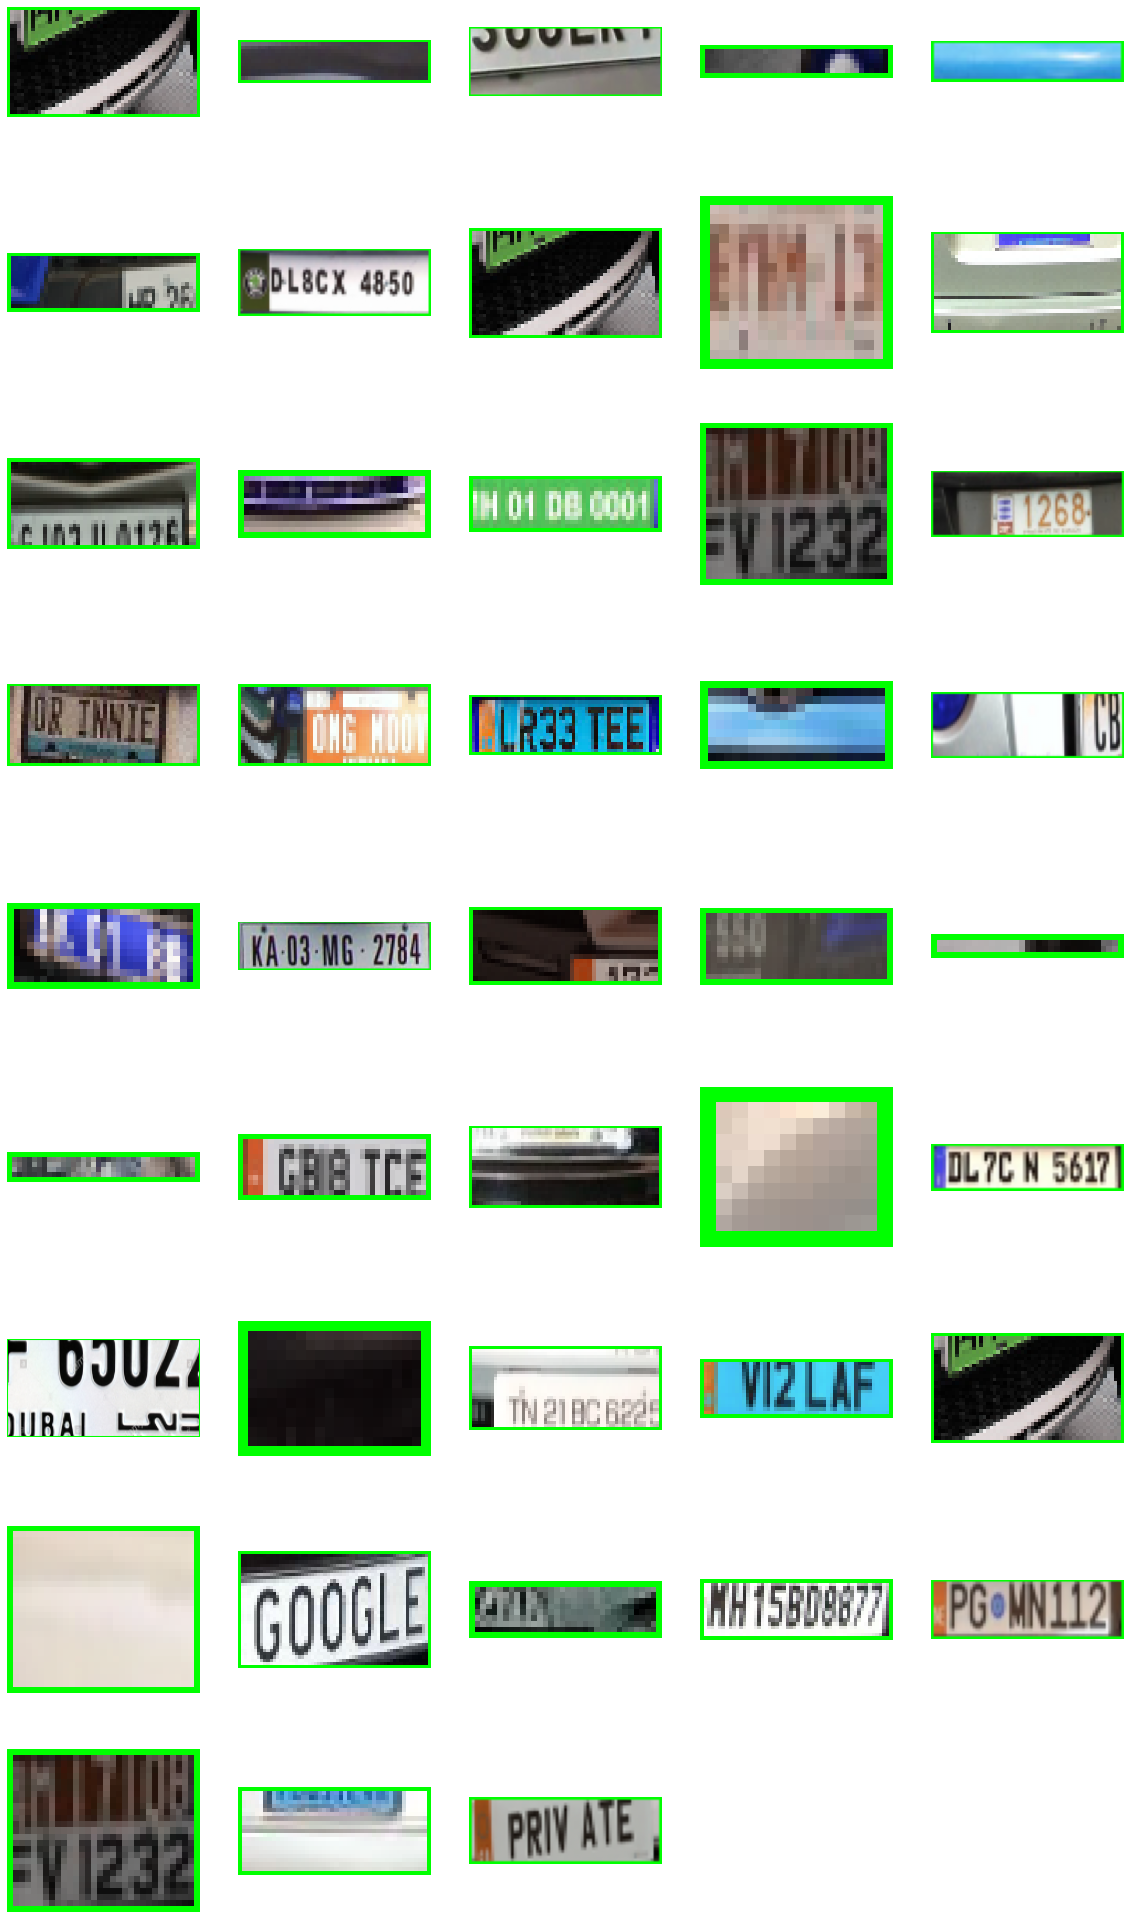

In [77]:
plates_list = []

for i in range(len(X_test)):
  ny = y_cnn[i]*255
    
  x_start = int(ny[0])+1
  y_start = int(ny[1])+1
  x_end = int(ny[2])
  y_end = int(ny[3])
  plates_list.append(X_test[i][y_end:y_start,x_end:x_start])
  

plt.figure(figsize=(20,40))
for i in range(0,43) :
  plt.subplot(10,5,i+1)
  plt.axis('off')
  plt.imshow(plates_list[i])
  

In [157]:
!pip install scipy
!pip install pytesseract

In [160]:
!pip install tesseract
!pip install tesseract-ocr

     |████████████████████████████████| 45.6 MB 1.3 MB/s 
  Created wheel for tesseract: filename=tesseract-0.1.3-py3-none-any.whl size=45562569 sha256=07dc1d1cee8b21a4dc15bc5ae2a05995080115c39856e232c240e54d22873b5a
  Stored in directory: /root/.cache/pip/wheels/01/3f/af/2f732560b9c4e51dd131bcbc6b7466a3124d15ab3fd393f85a
Successfully built tesseract
  ERROR: Failed building wheel for tesseract-ocr
  Running setup.py clean for tesseract-ocr
Failed to build tesseract-ocr
    Running setup.py install for tesseract-ocr ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-kxkbenii/tesseract-ocr_ad7a9403c7b44793855d05d55afd4888/setup.py'"'"'; __file__='"'"'/tmp/pip-install-kxkbenii/tesseract-ocr_ad7a9403c7b44793855d05d55afd4888/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"')

In [162]:
import pytesseract # this is tesseract module
test_image_dir = 'drive/My Drive/test_img_ML1.jpg'  # Image of any egyptian car with plate

test_image = cv2.imread(test_image_dir) # Image of any egyptian car with plate

text = pytesseract.image_to_string(test_image, config='--psm 11')
print(text)
# new_predicted_result_GWT2180 = pytesseract.image_to_string(test_image, lang ='eng',config ='--oem 3 -l eng --psm 6 -c tessedit_char_whitelist = ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
# filter_new_predicted_result_GWT2180 = "".join(new_predicted_result_GWT2180.split()).replace(":", "").replace("-", "")
# print(filter_new_predicted_result_GWT2180)

TesseractNotFoundError: ignored

[]


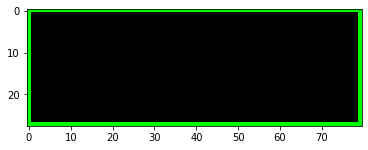

In [152]:
from easyocr import recognition
import pytesseract # this is tesseract module




# plt.imshow(test_image)

image = plates_list[6]

image *= 255/image.max() 

image = np.array(image, np.uint8)

# uint8_plate = image.astype(np.uint8)
plt.imshow(image)


kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
image_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
# image_sharp = cv2.dilate(image_sharp, kernel, iterations=1)

reader = easyocr.Reader(['en'])
result = reader.readtext(image_sharp)
print(str(result))

# uint8_plate2 = image_sharp.astype(np.uint8)
# result2 = reader.readtext(uint8_plate2)
# print(str(result2))



# for i in range(len(plates_list)):
#   reader = easyocr.Reader(['en'])
#   uint8_plate = plates_list[i].astype(np.uint8)
#   result = reader.readtext(uint8_plate)
#   print(str(result))

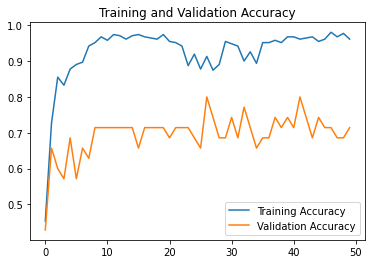

In [78]:
plt.figure()
plt.plot(range(50), train.history['accuracy'], label='Training Accuracy')
plt.plot(range(50), train.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

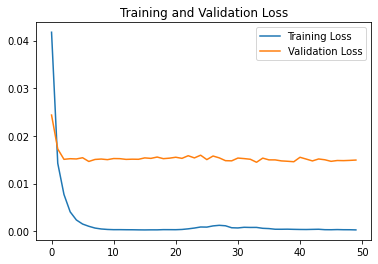

In [79]:
plt.figure()
plt.plot(range(50), train.history['loss'], label='Training Loss')
plt.plot(range(50), train.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Custom Test

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list
  
  char = segment_characters(plate)

In [ ]:
my_img_dir = "../input/my_images" # Enter Directory of your images that you just uploaded to Kaggle 
my_data_path = os.path.join(my_img_dir,'*g')
my_files = glob.glob(my_data_path)

create your test matrix

my_X_test=[]
for f1 in my_files:
img = cv2.imread(f1)
img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
my_X_test.append(np.array(img))

my_X_test=np.array(my_X_test)/255 # normalize it

y_cnn_new = model.predict(my_X_test)

SyntaxError: ignored

# Egypt Plate Detection (Old) 😞

In [80]:
!pip install easyocr
!pip install imutils

     |████████████████████████████████| 63.6 MB 66 kB/s 
     |████████████████████████████████| 47.6 MB 1.7 MB/s 


In [86]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
from PIL import ImageFont, ImageDraw, Image
from google.colab import drive
import os
drive.mount("/content/drive")
datadir = 'drive/My Drive/Practical Deep Machine Learning/Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paths To Imports
fontpath = datadir+"/arial.ttf"   # Download arial.ttf to display arabic on images  
test_image = datadir+'/test-1.jpg'  # Image of any egyptian car with plate

In [ ]:
img = cv2.imread(test_image) # Image of any egyptian car with plate
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

In [ ]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 100) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [ ]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

location

In [ ]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [ ]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [90]:
test_image_dir = 'drive/My Drive/plate_test.PNG'  # Image of any egyptian car with plate
test_image = cv2.imread(test_image_dir) # Image of any egyptian car with plate

reader = easyocr.Reader(['en'])
uint8_plate = X_text[0].astype(np.uint8)
result = reader.readtext(uint8_plate)
print(str(result))

# for i in range(len(plates_list)):
#   reader = easyocr.Reader(['en'])
#   uint8_plate = plates_list[i].astype(np.uint8)
#   result = reader.readtext(uint8_plate)
#   print(str(result))

NameError: ignored

In [ ]:
text = str.upper(result[0][1])
font = ImageFont.truetype(fontpath, 32)
img_pil = Image.fromarray(img)
draw = ImageDraw.Draw(img_pil)
final = str(result[0][1])
temp = final.split(' ')
final = temp[1]+' '+temp[0][::-1]
draw.text((approx[0][0][0], approx[1][0][1]+60),  final, font = font, fill = (0, 255, 0, 0))
img = np.array(img_pil)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

.